<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/capsule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!git clone https://github.com/adambielski/CapsNet-pytorch
import sys, os
sys.path.append('/content/CapsNet-Pytorch')
os.chdir('/content/CapsNet-pytorch')

Cloning into 'CapsNet-pytorch'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [26]:
import torch

torch.cuda.empty_cache()
device = ("cuda" if torch.cuda.is_available() else "cpu")

from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [27]:
from net import CapsNetWithReconstruction, CapsNet, ReconstructionNet, MarginLoss

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow(img):
    img = img.cpu()
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    plt.imshow(img.resize(28,28))
    plt.show()


In [28]:
# load model
capsnet = CapsNet(3, 10)
reconstructionnet = ReconstructionNet(16, 10)
model = CapsNetWithReconstruction(capsnet, reconstructionnet)
model.to(device)

CapsNetWithReconstruction(
  (capsnet): CapsNet(
    (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (primaryCaps): PrimaryCapsLayer(
      (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
    )
    (digitCaps): CapsLayer(
      (routing_module): AgreementRouting()
    )
  )
  (reconstruction_net): ReconstructionNet(
    (fc1): Linear(in_features=160, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=784, bias=True)
  )
)

In [29]:
dataset = MNIST('./data', train=False, transform=ToTensor(), download=True)

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])


# Create datasets for training & validation, download if necessary
training_set = MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
validation_set = MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)



batch_size = 10


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Class labels
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


In [31]:

import argparse
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable

In [47]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=15, min_lr=1e-6)
loss_fn = MarginLoss(0.9, 0.1, 0.5)
reconstruction_alpha=0.0005

In [63]:
def train(epoch):

  model.train()
  for batch_idx, (data, target) in enumerate(training_loader):

    data, target = data.to(device), target.to(device)

    data, target = Variable(data), Variable(target, requires_grad=False)
    
    optimizer.zero_grad()

    # with reconstruction
    output, probs = model(data, target)
    
    reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
    margin_loss = loss_fn(probs, target)
    loss = reconstruction_alpha * reconstruction_loss + margin_loss
    
    # output, probs = model(data)
    # loss = loss_fn(probs, target)

    loss.backward()
    optimizer.step()

    # if batch_idx % 50 == 0:
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\t'.format(epoch, batch_idx * len(data), len(training_loader.dataset),100. * batch_idx / len(training_loader)))
  print('\nLoss: ',loss.item(),'\n')
  print('--------------------------------------------\n')

    

In [64]:
def test():

  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
      if True:
        data, target = data.cuda(), target.cuda()
      data, target = Variable(data, volatile=True), Variable(target)

      if True:
        output, probs = model(data, target)
        reconstruction_loss = F.mse_loss(output, data.view(-1, 784), size_average=False).item()
        test_loss += loss_fn(probs, target, size_average=False).item()
        test_loss += reconstruction_alpha * reconstruction_loss
      else:
        output, probs = model(data)
        test_loss += loss_fn(probs, target, size_average=False).item()

      pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
      correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(validation_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              test_loss, correct, len(validation_loader.dataset),
              100. * correct / len(validation_loader.dataset)))
    return test_loss

In [66]:
num_epoch=2
for epoch in range(1, num_epoch + 1):
  train(epoch)
  test_loss = test()
  scheduler.step(test_loss)
  torch.save(model.state_dict(),
                   '{:03d}_model_dict_{}.pth'.format(epoch, 3))

/content/CapsNet-pytorch/net.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/content/CapsNet-pytorch/net.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [59990/60000 (100%)]	

Loss:  0.00014646285853814334 

--------------------------------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0324, Accuracy: 9808/10000 (98%)

Train Epoch: 2 [59990/60000 (100%)]	

Loss:  7.118638313841075e-05 

--------------------------------------------


Test set: Average loss: 0.0297, Accuracy: 9859/10000 (99%)



/content/CapsNet-pytorch/net.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/content/CapsNet-pytorch/net.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


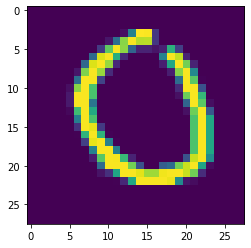

labels:  0
predicted:  0


In [98]:
import random


index = random.randint(0, 1000 - 1)

for i, data in enumerate(validation_loader):
  # Every data instance is an input + label pair
  if index==i:
    inputs, labels = data
          
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Make predictions for this batch
    outputs, probs = model(inputs, labels)

    pred = probs.data.max(1, keepdim=True)[1].cpu()
    
    imshow(inputs[0])
    print('labels: ',classes[labels[0]])
    print('predicted: ',pred[0][0].numpy())
    break